In [76]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import csv
import operator
%matplotlib inline

In [2]:
# we need formaula to compute distance between two points

#Since the distance is relatively small, you can use the equirectangular distance approximation
def haversine(point1, point2):
    # radius of the earth in km
    R = 6371 
    # get lat and lon
    lon1, lat1 = point1[0], point1[1]
    lon2, lat2 = point2[0], point2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # formula
    x = (lon2 - lon1) * math.cos( 0.5*(lat2+lat1) )
    y = lat2 - lat1
    d = R * math.sqrt( x*x + y*y )
    return d


In [3]:
# Longitude and latitude coordinates of Porto
point_mid = [-8.6109900, 41.1496100] #lon, lat

#Porto airport coordinates
point_air = [-8.671403, 41.237137]

## 1. Data loading and selection

In [12]:
# Load the data
#zf = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv('train.csv', 
                 sep = ",",
                 chunksize = 1000,
                 iterator = True,
                 usecols = ['POLYLINE', 'MISSING_DATA'],
                 converters={'POLYLINE': lambda x: json.loads(x)})

In [13]:
initial_radius = 1.5 #km
#df_airport = pd.DataFrame()

In [14]:
traj_df = pd.DataFrame()

for data in df:
    #print data
    for index, row in data.iterrows():
        if len(row["POLYLINE"]) > 0:
            if haversine(row["POLYLINE"][0], point_air) <= initial_radius:
                row['Destination'] = row['POLYLINE'][-1]
                traj_df = traj_df.append(row, ignore_index=True)

In [60]:
air_traj_list = []
for data in df:
    #print data['POLYLINE']
    for coords in data['POLYLINE']:
        if len(coords) > 0:
            if haversine(coords[0], point_air) <= initial_radius:
                #print "Yes"
                air_traj_list.append(coords)
                
    break
    

In [22]:
traj_df['MISSING_DATA'].value_counts()

0    4328
Name: MISSING_DATA, dtype: int64

In [23]:
traj_df.to_csv('air_trajs.csv')
#df.to_csv(file_name, sep='\t')

In [50]:
with open("air_traj.csv", "wb") as f:
    writer = csv.writer(f, delimiter=',',
                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerows(air_traj_list)

In [86]:
# Let's see end points of selected trips

In [130]:
start_points = np.array([trip[0] for trip in air_traj_list])
end_points = np.array([trip[-1] for trip in air_traj_list])
latlong = end_points.copy()

In [101]:
# cut off long distance trips
lat_low, lat_hgh = np.percentile(latlong[:,0], [2, 98])
lon_low, lon_hgh = np.percentile(latlong[:,1], [2, 98])

# create image
bins = 513
lat_bins = np.linspace(lat_low, lat_hgh, bins)
lon_bins = np.linspace(lon_low, lon_hgh, bins)
H2, _, _ = np.histogram2d(latlong[:,0], latlong[:,1], bins=(lat_bins, lon_bins))

img = np.log(H2[::-1, :] + 1)

plt.figure()
ax = plt.subplot(1,1,1)
plt.imshow(img)
plt.axis('off')
plt.title('Taxi trip end points')
plt.savefig("taxi_trip_end_points.png")

In [131]:
start_lats = [p[1] for p in start_points]
start_lons = [p[0] for p in start_points]

end_lats = [p[1] for p in end_points]
end_lons = [p[0] for p in end_points]


In [135]:
import gmplot

gmap = gmplot.GoogleMapPlotter(41.1496100, -8.6109900 , 12)

#gmap.plot(heat_lats, heat_lons, 'cornflowerblue', edge_width=10)
#gmap.scatter(heat_lats, heat_lons, '#3B0B39', size=10, marker=False)
gmap.scatter(start_lats, start_lons, '#006400', size=10, marker=False)
gmap.scatter(end_lats, end_lons, '#8B0000', size=10, marker=False)

#gmap.heatmap(heat_lats, heat_lons)

gmap.draw("mymap.html")

## 2. Work with extracted data

In [4]:
air_trajs = pd.read_csv('air_trajs.csv',
                        #index_col=,
                        usecols = ['POLYLINE', 'Destination'],
                        converters={'POLYLINE': lambda x: json.loads(x), 'Destination': lambda x: json.loads(x)})

In [5]:
decision_points = []
end_points = np.array([trip[-1] for trip in air_trajs['POLYLINE']])
start_points = np.array([trip[0] for trip in air_trajs['POLYLINE']])

In [6]:
def mean_points_alpha(points):
    lats = [point[0] for point in points]
    lons = [point[1] for point in points]
    return [np.mean(lats), np.mean(lons)]

def sqare_error_alpha(points):
    pmean = mean_points_alpha(points)
    #print np.mean(np.power([haversine(point, pmean) for point in points], 2))
    return np.mean(np.power([haversine(point, pmean) for point in points], 2))
    
def index_points_in_circe(center, radius, points):
    indexes = []
    for index, point in points.iteritems():
        if haversine(center, point) <= radius:
            indexes.append(index)
            
    return indexes


In [106]:
def find_decision_point(trajs, targets):
    eps = 0.001
    gains = []
    
    start_points = trajs.copy()
    for index, row in start_points.iteritems():
        start_points[index] = row[0]
    
    for index, point in start_points[2:5].iteritems():
        p_gains = []
        nn = 1
        radius = eps
        p_error = sqare_error_alpha(targets)
        print 'start'
        
        while(nn < len(start_points)):
            n_indexes = index_points_in_circe(point, radius, start_points)

            if nn < len(n_indexes):
                nn = len(n_indexes)
                
                mse_in = float(len(n_indexes))/len(targets) * sqare_error_alpha(targets[n_indexes])
                mse_out = float(len(targets) - len(n_indexes))/len(targets) * sqare_error_alpha(targets.drop(n_indexes))
                
                gain = p_error - (mse_in + mse_out)
                p_gains.append((index, radius, gain))
                
                radius += eps
            else:
                radius += eps
                
        gains.append(max(p_gains, key=operator.itemgetter(2)))
        
    best_gain = max(gains, key=operator.itemgetter(2))
    d_point = (start_points[best_gain[0]], best_gain[1])

    return d_point
    

In [107]:
gains = find_decision_point(air_trajs['POLYLINE'], air_trajs['Destination'])

start
start
start


In [108]:
gains

([-8.670006, 41.2371], 0.05300000000000004)

In [97]:
gains

[(2, 0.35700000000000026, 0.49975287435910332),
 (3, 0.05300000000000004, 1.1289725302015086),
 (4, 0.22700000000000017, 1.0824562959805348)]

In [103]:
best = max(gains, key=operator.itemgetter(2))
best[0]

3

In [104]:
air_trajs['Destination'][best[0]]

[-8.668224, 41.238657]

In [137]:
x = range(len(sigmas))
sigmas = np.array(sigmas)
neighbors = np.array(neighbors)
print np.where(np.log(sigmas)/neighbors==min(np.log(sigmas)/neighbors))
print np.where(np.log(sigmas/neighbors)==min(np.log(sigmas/neighbors)))
print np.where(sigmas/np.log(neighbors)==min(sigmas/np.log(neighbors)))

(array([811]),)
(array([811]),)
(array([0]),)


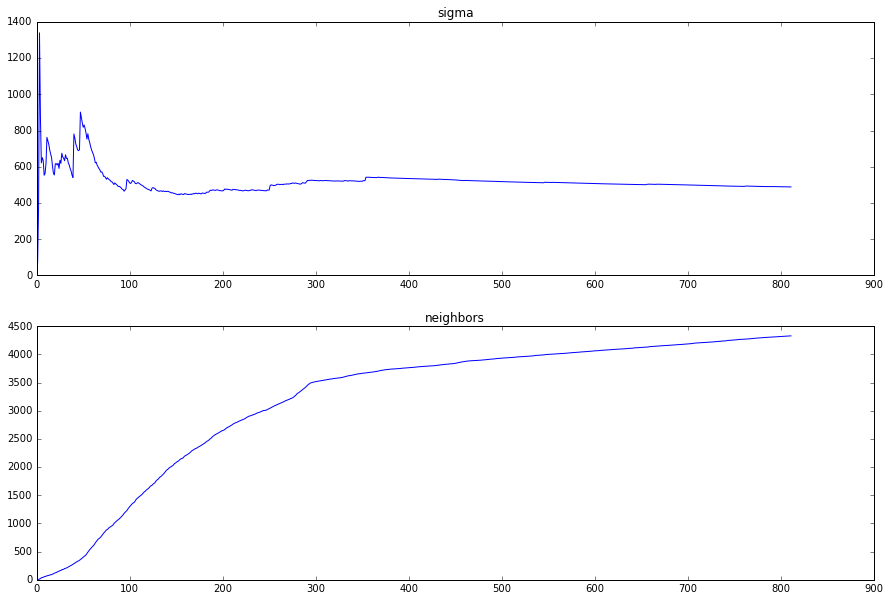

In [138]:
plt.figure(1, figsize=(15,10))
plt.subplot(211)
plt.title('sigma')
plt.plot(x, sigmas)

plt.subplot(212)
plt.title('neighbors')
plt.plot(x, neighbors)

plt.show()

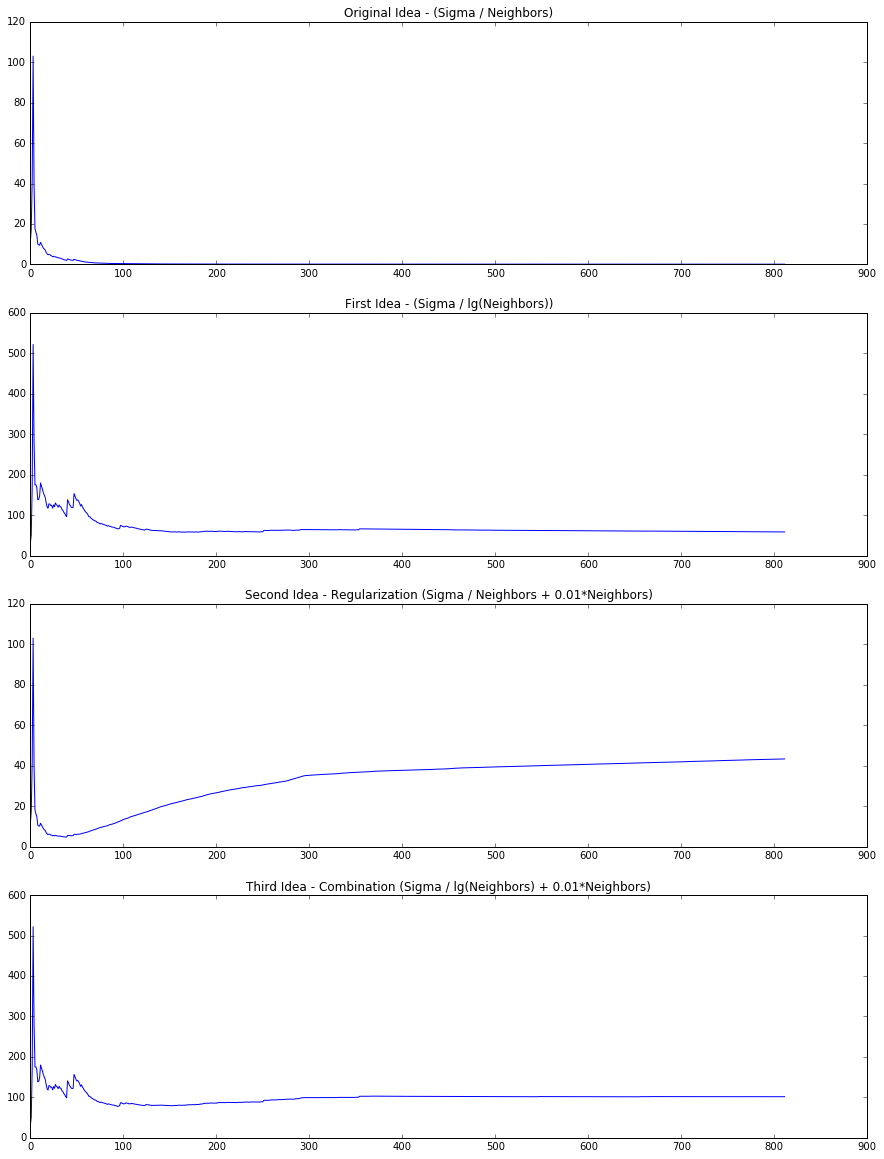

In [145]:
plt.figure(1, figsize=(15,20))
plt.subplot(411)
plt.title('Original Idea - (Sigma / Neighbors)')
plt.plot(x, sigmas/neighbors)

plt.subplot(412)
plt.title('First Idea - (Sigma / lg(Neighbors))')
plt.plot(x, sigmas/np.log(neighbors))

plt.subplot(413)
plt.title('Second Idea - Regularization (Sigma / Neighbors + 0.01*Neighbors)')
plt.plot(x, sigmas/neighbors+0.01*neighbors)

plt.subplot(414)
plt.title('Third Idea - Combination (Sigma / lg(Neighbors) + 0.01*Neighbors)')
plt.plot(x, sigmas/np.log(neighbors)+0.01*neighbors)

plt.show()

In [146]:
idea = sigmas/neighbors+0.01*neighbors**2
print np.where(idea==min(idea))

(array([0]),)


In [41]:
x = range(len(sigmas))
sigmas = np.array(sigmas)
print np.where((sigmas)==min(sigmas))
print len(x)

(array([810]),)
812


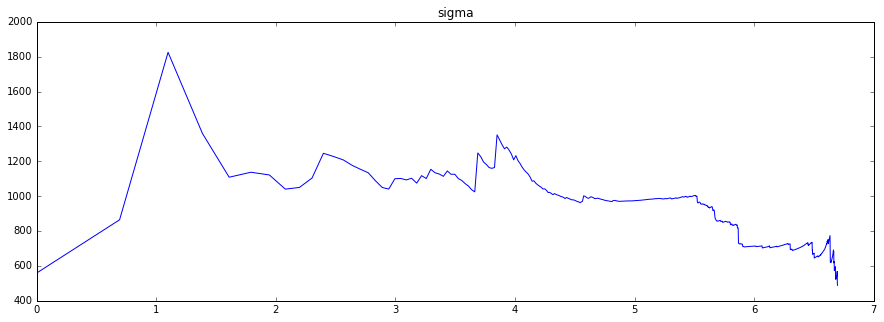

In [44]:
plt.figure(1, figsize=(15,5))
plt.subplot(111)
plt.title('sigma')
plt.plot(np.log(x), sigmas)

plt.show()

In [72]:
x = range(len(gains))
sigmas = np.array(gains)
print np.where((gains)==max(gains))
print len(x)

(array([337]),)
804


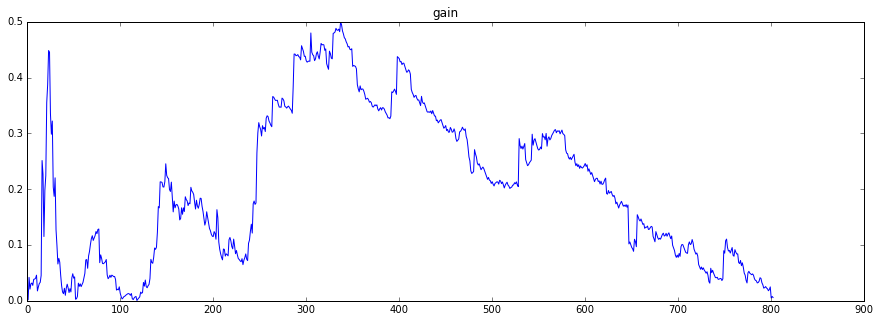

In [73]:
plt.figure(1, figsize=(15,5))
plt.subplot(111)
plt.title('gain')
plt.plot(x, gains)

plt.show()